# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            #nn.SELU(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            #nn.SELU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 32 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/25, Loss: 0.8749
Epoch 1/200, Iteration 2/25, Loss: 0.7767
Epoch 1/200, Iteration 3/25, Loss: 1.7036
Epoch 1/200, Iteration 4/25, Loss: 1.2979
Epoch 1/200, Iteration 5/25, Loss: 0.5643
Epoch 1/200, Iteration 6/25, Loss: 0.5139
Epoch 1/200, Iteration 7/25, Loss: 0.5999
Epoch 1/200, Iteration 8/25, Loss: 0.6088
Epoch 1/200, Iteration 9/25, Loss: 0.5327
Epoch 1/200, Iteration 10/25, Loss: 0.4601
Epoch 1/200, Iteration 11/25, Loss: 0.5956
Epoch 1/200, Iteration 12/25, Loss: 0.5676
Epoch 1/200, Iteration 13/25, Loss: 0.4947
Epoch 1/200, Iteration 14/25, Loss: 0.3561
Epoch 1/200, Iteration 15/25, Loss: 0.2426
Epoch 1/200, Iteration 16/25, Loss: 0.3069
Epoch 1/200, Iteration 17/25, Loss: 0.3660
Epoch 1/200, Iteration 18/25, Loss: 0.3445
Epoch 1/200, Iteration 19/25, Loss: 0.3483
Epoch 1/200, Iteration 20/25, Loss: 0.3272
Epoch 1/200, Iteration 21/25, Loss: 0.3172
Epoch 1/200, Iteration 22/25, Loss: 0.2818
Epoch 1/200, Iteration 23/25, Loss: 0.3374
Epoch 1/200, Iterati

Train Error: 
 Accuracy: 93.0%, Avg loss: 0.174243, MRE: 0.108439, MAE: 0.020564 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.164237, MRE: 0.093744, MAE: 0.019300 

Epoch 8/200, Iteration 1/25, Loss: 0.2062
Epoch 8/200, Iteration 2/25, Loss: 0.1818
Epoch 8/200, Iteration 3/25, Loss: 0.1639
Epoch 8/200, Iteration 4/25, Loss: 0.1800
Epoch 8/200, Iteration 5/25, Loss: 0.1744
Epoch 8/200, Iteration 6/25, Loss: 0.1692
Epoch 8/200, Iteration 7/25, Loss: 0.1920
Epoch 8/200, Iteration 8/25, Loss: 0.1858
Epoch 8/200, Iteration 9/25, Loss: 0.2233
Epoch 8/200, Iteration 10/25, Loss: 0.1623
Epoch 8/200, Iteration 11/25, Loss: 0.2560
Epoch 8/200, Iteration 12/25, Loss: 0.2929
Epoch 8/200, Iteration 13/25, Loss: 0.1756
Epoch 8/200, Iteration 14/25, Loss: 0.1593
Epoch 8/200, Iteration 15/25, Loss: 0.2464
Epoch 8/200, Iteration 16/25, Loss: 0.2101
Epoch 8/200, Iteration 17/25, Loss: 0.1822
Epoch 8/200, Iteration 18/25, Loss: 0.1929
Epoch 8/200, Iteration 19/25, Loss: 0.1540
Epoch 8/200, Iteration 20/2

Train Error: 
 Accuracy: 62.5%, Avg loss: 0.141162, MRE: 0.091567, MAE: 0.018494 

Test Error: 
 Accuracy: 65.5%, Avg loss: 0.129305, MRE: 0.076937, MAE: 0.017695 

Epoch 15/200, Iteration 1/25, Loss: 0.1316
Epoch 15/200, Iteration 2/25, Loss: 0.1840
Epoch 15/200, Iteration 3/25, Loss: 0.1451
Epoch 15/200, Iteration 4/25, Loss: 0.1485
Epoch 15/200, Iteration 5/25, Loss: 0.2047
Epoch 15/200, Iteration 6/25, Loss: 0.1532
Epoch 15/200, Iteration 7/25, Loss: 0.1582
Epoch 15/200, Iteration 8/25, Loss: 0.1559
Epoch 15/200, Iteration 9/25, Loss: 0.1414
Epoch 15/200, Iteration 10/25, Loss: 0.1688
Epoch 15/200, Iteration 11/25, Loss: 0.1501
Epoch 15/200, Iteration 12/25, Loss: 0.1496
Epoch 15/200, Iteration 13/25, Loss: 0.1147
Epoch 15/200, Iteration 14/25, Loss: 0.1629
Epoch 15/200, Iteration 15/25, Loss: 0.1245
Epoch 15/200, Iteration 16/25, Loss: 0.1768
Epoch 15/200, Iteration 17/25, Loss: 0.1134
Epoch 15/200, Iteration 18/25, Loss: 0.1737
Epoch 15/200, Iteration 19/25, Loss: 0.2113
Epoch 15

Epoch 21/200, Iteration 19/25, Loss: 0.0385
Epoch 21/200, Iteration 20/25, Loss: 0.0273
Epoch 21/200, Iteration 21/25, Loss: 0.0263
Epoch 21/200, Iteration 22/25, Loss: 0.0265
Epoch 21/200, Iteration 23/25, Loss: 0.0465
Epoch 21/200, Iteration 24/25, Loss: 0.0314
Epoch 21/200, Iteration 25/25, Loss: 0.0296
Train Error: 
 Accuracy: 98.38%, Avg loss: 0.031879, MRE: 0.027064, MAE: 0.004365 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.032782, MRE: 0.020689, MAE: 0.004438 

Epoch 22/200, Iteration 1/25, Loss: 0.0315
Epoch 22/200, Iteration 2/25, Loss: 0.0299
Epoch 22/200, Iteration 3/25, Loss: 0.0315
Epoch 22/200, Iteration 4/25, Loss: 0.0398
Epoch 22/200, Iteration 5/25, Loss: 0.0289
Epoch 22/200, Iteration 6/25, Loss: 0.0379
Epoch 22/200, Iteration 7/25, Loss: 0.0334
Epoch 22/200, Iteration 8/25, Loss: 0.0329
Epoch 22/200, Iteration 9/25, Loss: 0.0324
Epoch 22/200, Iteration 10/25, Loss: 0.0302
Epoch 22/200, Iteration 11/25, Loss: 0.0233
Epoch 22/200, Iteration 12/25, Loss: 0.0259
Epoch 2

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.028194, MRE: 0.022483, MAE: 0.003448 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.030742, MRE: 0.021801, MAE: 0.003774 

Epoch 29/200, Iteration 1/25, Loss: 0.0313
Epoch 29/200, Iteration 2/25, Loss: 0.0267
Epoch 29/200, Iteration 3/25, Loss: 0.0275
Epoch 29/200, Iteration 4/25, Loss: 0.0215
Epoch 29/200, Iteration 5/25, Loss: 0.0301
Epoch 29/200, Iteration 6/25, Loss: 0.0244
Epoch 29/200, Iteration 7/25, Loss: 0.0207
Epoch 29/200, Iteration 8/25, Loss: 0.0222
Epoch 29/200, Iteration 9/25, Loss: 0.0267
Epoch 29/200, Iteration 10/25, Loss: 0.0256
Epoch 29/200, Iteration 11/25, Loss: 0.0348
Epoch 29/200, Iteration 12/25, Loss: 0.0228
Epoch 29/200, Iteration 13/25, Loss: 0.0248
Epoch 29/200, Iteration 14/25, Loss: 0.0285
Epoch 29/200, Iteration 15/25, Loss: 0.0173
Epoch 29/200, Iteration 16/25, Loss: 0.0235
Epoch 29/200, Iteration 17/25, Loss: 0.0254
Epoch 29/200, Iteration 18/25, Loss: 0.0296
Epoch 29/200, Iteration 19/25, Loss: 0.0231
Epoch 2

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.027534, MRE: 0.019635, MAE: 0.003572 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.030337, MRE: 0.018758, MAE: 0.003831 

Epoch 36/200, Iteration 1/25, Loss: 0.0261
Epoch 36/200, Iteration 2/25, Loss: 0.0238
Epoch 36/200, Iteration 3/25, Loss: 0.0202
Epoch 36/200, Iteration 4/25, Loss: 0.0243
Epoch 36/200, Iteration 5/25, Loss: 0.0265
Epoch 36/200, Iteration 6/25, Loss: 0.0271
Epoch 36/200, Iteration 7/25, Loss: 0.0304
Epoch 36/200, Iteration 8/25, Loss: 0.0275
Epoch 36/200, Iteration 9/25, Loss: 0.0228
Epoch 36/200, Iteration 10/25, Loss: 0.0256
Epoch 36/200, Iteration 11/25, Loss: 0.0290
Epoch 36/200, Iteration 12/25, Loss: 0.0237
Epoch 36/200, Iteration 13/25, Loss: 0.0336
Epoch 36/200, Iteration 14/25, Loss: 0.0333
Epoch 36/200, Iteration 15/25, Loss: 0.0294
Epoch 36/200, Iteration 16/25, Loss: 0.0307
Epoch 36/200, Iteration 17/25, Loss: 0.0287
Epoch 36/200, Iteration 18/25, Loss: 0.0274
Epoch 36/200, Iteration 19/25, Loss: 0.0270
Epoch 3

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.022928, MRE: 0.017548, MAE: 0.003135 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.025106, MRE: 0.017979, MAE: 0.003325 

Epoch 43/200, Iteration 1/25, Loss: 0.0265
Epoch 43/200, Iteration 2/25, Loss: 0.0165
Epoch 43/200, Iteration 3/25, Loss: 0.0222
Epoch 43/200, Iteration 4/25, Loss: 0.0250
Epoch 43/200, Iteration 5/25, Loss: 0.0271
Epoch 43/200, Iteration 6/25, Loss: 0.0355
Epoch 43/200, Iteration 7/25, Loss: 0.0233
Epoch 43/200, Iteration 8/25, Loss: 0.0216
Epoch 43/200, Iteration 9/25, Loss: 0.0304
Epoch 43/200, Iteration 10/25, Loss: 0.0267
Epoch 43/200, Iteration 11/25, Loss: 0.0184
Epoch 43/200, Iteration 12/25, Loss: 0.0253
Epoch 43/200, Iteration 13/25, Loss: 0.0226
Epoch 43/200, Iteration 14/25, Loss: 0.0201
Epoch 43/200, Iteration 15/25, Loss: 0.0244
Epoch 43/200, Iteration 16/25, Loss: 0.0208
Epoch 43/200, Iteration 17/25, Loss: 0.0248
Epoch 43/200, Iteration 18/25, Loss: 0.0278
Epoch 43/200, Iteration 19/25, Loss: 0.0279
Epoch 4

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.009410, MRE: 0.007867, MAE: 0.001234 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.016185, MRE: 0.010066, MAE: 0.002034 

Epoch 50/200, Iteration 1/25, Loss: 0.0113
Epoch 50/200, Iteration 2/25, Loss: 0.0096
Epoch 50/200, Iteration 3/25, Loss: 0.0080
Epoch 50/200, Iteration 4/25, Loss: 0.0092
Epoch 50/200, Iteration 5/25, Loss: 0.0090
Epoch 50/200, Iteration 6/25, Loss: 0.0098
Epoch 50/200, Iteration 7/25, Loss: 0.0111
Epoch 50/200, Iteration 8/25, Loss: 0.0099
Epoch 50/200, Iteration 9/25, Loss: 0.0102
Epoch 50/200, Iteration 10/25, Loss: 0.0107
Epoch 50/200, Iteration 11/25, Loss: 0.0101
Epoch 50/200, Iteration 12/25, Loss: 0.0114
Epoch 50/200, Iteration 13/25, Loss: 0.0091
Epoch 50/200, Iteration 14/25, Loss: 0.0108
Epoch 50/200, Iteration 15/25, Loss: 0.0103
Epoch 50/200, Iteration 16/25, Loss: 0.0089
Epoch 50/200, Iteration 17/25, Loss: 0.0105
Epoch 50/200, Iteration 18/25, Loss: 0.0090
Epoch 50/200, Iteration 19/25, Loss: 0.0094
Epoch 5

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015300, MRE: 0.009306, MAE: 0.001925 

Epoch 57/200, Iteration 1/25, Loss: 0.0065
Epoch 57/200, Iteration 2/25, Loss: 0.0089
Epoch 57/200, Iteration 3/25, Loss: 0.0071
Epoch 57/200, Iteration 4/25, Loss: 0.0086
Epoch 57/200, Iteration 5/25, Loss: 0.0101
Epoch 57/200, Iteration 6/25, Loss: 0.0095
Epoch 57/200, Iteration 7/25, Loss: 0.0088
Epoch 57/200, Iteration 8/25, Loss: 0.0078
Epoch 57/200, Iteration 9/25, Loss: 0.0089
Epoch 57/200, Iteration 10/25, Loss: 0.0100
Epoch 57/200, Iteration 11/25, Loss: 0.0079
Epoch 57/200, Iteration 12/25, Loss: 0.0092
Epoch 57/200, Iteration 13/25, Loss: 0.0086
Epoch 57/200, Iteration 14/25, Loss: 0.0085
Epoch 57/200, Iteration 15/25, Loss: 0.0079
Epoch 57/200, Iteration 16/25, Loss: 0.0099
Epoch 57/200, Iteration 17/25, Loss: 0.0113
Epoch 57/200, Iteration 18/25, Loss: 0.0075
Epoch 57/200, Iteration 19/25, Loss: 0.0069
Epoch 57/200, Iteration 20/25, Loss: 0.0074
Epoch 57/200, Iteration 21/25, Loss: 0.0085
Epo

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008683, MRE: 0.006825, MAE: 0.001140 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.015362, MRE: 0.009307, MAE: 0.001929 

Epoch 64/200, Iteration 1/25, Loss: 0.0081
Epoch 64/200, Iteration 2/25, Loss: 0.0077
Epoch 64/200, Iteration 3/25, Loss: 0.0075
Epoch 64/200, Iteration 4/25, Loss: 0.0075
Epoch 64/200, Iteration 5/25, Loss: 0.0103
Epoch 64/200, Iteration 6/25, Loss: 0.0108
Epoch 64/200, Iteration 7/25, Loss: 0.0090
Epoch 64/200, Iteration 8/25, Loss: 0.0086
Epoch 64/200, Iteration 9/25, Loss: 0.0093
Epoch 64/200, Iteration 10/25, Loss: 0.0080
Epoch 64/200, Iteration 11/25, Loss: 0.0091
Epoch 64/200, Iteration 12/25, Loss: 0.0065
Epoch 64/200, Iteration 13/25, Loss: 0.0101
Epoch 64/200, Iteration 14/25, Loss: 0.0075
Epoch 64/200, Iteration 15/25, Loss: 0.0071
Epoch 64/200, Iteration 16/25, Loss: 0.0066
Epoch 64/200, Iteration 17/25, Loss: 0.0069
Epoch 64/200, Iteration 18/25, Loss: 0.0120
Epoch 64/200, Iteration 19/25, Loss: 0.0072
Epoch 6

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008413, MRE: 0.006858, MAE: 0.001118 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014598, MRE: 0.009447, MAE: 0.001851 

Epoch 71/200, Iteration 1/25, Loss: 0.0088
Epoch 71/200, Iteration 2/25, Loss: 0.0085
Epoch 71/200, Iteration 3/25, Loss: 0.0089
Epoch 71/200, Iteration 4/25, Loss: 0.0069
Epoch 71/200, Iteration 5/25, Loss: 0.0078
Epoch 71/200, Iteration 6/25, Loss: 0.0067
Epoch 71/200, Iteration 7/25, Loss: 0.0071
Epoch 71/200, Iteration 8/25, Loss: 0.0077
Epoch 71/200, Iteration 9/25, Loss: 0.0090
Epoch 71/200, Iteration 10/25, Loss: 0.0073
Epoch 71/200, Iteration 11/25, Loss: 0.0066
Epoch 71/200, Iteration 12/25, Loss: 0.0108
Epoch 71/200, Iteration 13/25, Loss: 0.0073
Epoch 71/200, Iteration 14/25, Loss: 0.0086
Epoch 71/200, Iteration 15/25, Loss: 0.0088
Epoch 71/200, Iteration 16/25, Loss: 0.0077
Epoch 71/200, Iteration 17/25, Loss: 0.0118
Epoch 71/200, Iteration 18/25, Loss: 0.0069
Epoch 71/200, Iteration 19/25, Loss: 0.0076
Epoch 7

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006904, MRE: 0.005947, MAE: 0.000926 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.013732, MRE: 0.008639, MAE: 0.001731 

Epoch 78/200, Iteration 1/25, Loss: 0.0065
Epoch 78/200, Iteration 2/25, Loss: 0.0049
Epoch 78/200, Iteration 3/25, Loss: 0.0069
Epoch 78/200, Iteration 4/25, Loss: 0.0059
Epoch 78/200, Iteration 5/25, Loss: 0.0071
Epoch 78/200, Iteration 6/25, Loss: 0.0077
Epoch 78/200, Iteration 7/25, Loss: 0.0062
Epoch 78/200, Iteration 8/25, Loss: 0.0086
Epoch 78/200, Iteration 9/25, Loss: 0.0086
Epoch 78/200, Iteration 10/25, Loss: 0.0059
Epoch 78/200, Iteration 11/25, Loss: 0.0081
Epoch 78/200, Iteration 12/25, Loss: 0.0074
Epoch 78/200, Iteration 13/25, Loss: 0.0070
Epoch 78/200, Iteration 14/25, Loss: 0.0123
Epoch 78/200, Iteration 15/25, Loss: 0.0092
Epoch 78/200, Iteration 16/25, Loss: 0.0078
Epoch 78/200, Iteration 17/25, Loss: 0.0073
Epoch 78/200, Iteration 18/25, Loss: 0.0083
Epoch 78/200, Iteration 19/25, Loss: 0.0066
Epoch 7

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.007030, MRE: 0.005590, MAE: 0.000967 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.013848, MRE: 0.008686, MAE: 0.001776 

Epoch 85/200, Iteration 1/25, Loss: 0.0067
Epoch 85/200, Iteration 2/25, Loss: 0.0079
Epoch 85/200, Iteration 3/25, Loss: 0.0082
Epoch 85/200, Iteration 4/25, Loss: 0.0060
Epoch 85/200, Iteration 5/25, Loss: 0.0057
Epoch 85/200, Iteration 6/25, Loss: 0.0062
Epoch 85/200, Iteration 7/25, Loss: 0.0061
Epoch 85/200, Iteration 8/25, Loss: 0.0070
Epoch 85/200, Iteration 9/25, Loss: 0.0071
Epoch 85/200, Iteration 10/25, Loss: 0.0064
Epoch 85/200, Iteration 11/25, Loss: 0.0071
Epoch 85/200, Iteration 12/25, Loss: 0.0063
Epoch 85/200, Iteration 13/25, Loss: 0.0058
Epoch 85/200, Iteration 14/25, Loss: 0.0068
Epoch 85/200, Iteration 15/25, Loss: 0.0059
Epoch 85/200, Iteration 16/25, Loss: 0.0054
Epoch 85/200, Iteration 17/25, Loss: 0.0093
Epoch 85/200, Iteration 18/25, Loss: 0.0079
Epoch 85/200, Iteration 19/25, Loss: 0.0069
Epoch 8

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007094, MRE: 0.005545, MAE: 0.000959 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.013551, MRE: 0.008578, MAE: 0.001718 

Epoch 92/200, Iteration 1/25, Loss: 0.0063
Epoch 92/200, Iteration 2/25, Loss: 0.0062
Epoch 92/200, Iteration 3/25, Loss: 0.0053
Epoch 92/200, Iteration 4/25, Loss: 0.0066
Epoch 92/200, Iteration 5/25, Loss: 0.0058
Epoch 92/200, Iteration 6/25, Loss: 0.0070
Epoch 92/200, Iteration 7/25, Loss: 0.0062
Epoch 92/200, Iteration 8/25, Loss: 0.0073
Epoch 92/200, Iteration 9/25, Loss: 0.0069
Epoch 92/200, Iteration 10/25, Loss: 0.0067
Epoch 92/200, Iteration 11/25, Loss: 0.0062
Epoch 92/200, Iteration 12/25, Loss: 0.0099
Epoch 92/200, Iteration 13/25, Loss: 0.0071
Epoch 92/200, Iteration 14/25, Loss: 0.0063
Epoch 92/200, Iteration 15/25, Loss: 0.0074
Epoch 92/200, Iteration 16/25, Loss: 0.0076
Epoch 92/200, Iteration 17/25, Loss: 0.0077
Epoch 92/200, Iteration 18/25, Loss: 0.0061
Epoch 92/200, Iteration 19/25, Loss: 0.0073
Epoch 9

Epoch 98/200, Iteration 19/25, Loss: 0.0057
Epoch 98/200, Iteration 20/25, Loss: 0.0048
Epoch 98/200, Iteration 21/25, Loss: 0.0079
Epoch 98/200, Iteration 22/25, Loss: 0.0079
Epoch 98/200, Iteration 23/25, Loss: 0.0085
Epoch 98/200, Iteration 24/25, Loss: 0.0057
Epoch 98/200, Iteration 25/25, Loss: 0.0091
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.007319, MRE: 0.006072, MAE: 0.000995 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.013357, MRE: 0.008289, MAE: 0.001711 

Epoch 99/200, Iteration 1/25, Loss: 0.0075
Epoch 99/200, Iteration 2/25, Loss: 0.0067
Epoch 99/200, Iteration 3/25, Loss: 0.0073
Epoch 99/200, Iteration 4/25, Loss: 0.0069
Epoch 99/200, Iteration 5/25, Loss: 0.0077
Epoch 99/200, Iteration 6/25, Loss: 0.0070
Epoch 99/200, Iteration 7/25, Loss: 0.0065
Epoch 99/200, Iteration 8/25, Loss: 0.0070
Epoch 99/200, Iteration 9/25, Loss: 0.0053
Epoch 99/200, Iteration 10/25, Loss: 0.0064
Epoch 99/200, Iteration 11/25, Loss: 0.0080
Epoch 99/200, Iteration 12/25, Loss: 0.0059
Epoch 9

Epoch 105/200, Iteration 20/25, Loss: 0.0055
Epoch 105/200, Iteration 21/25, Loss: 0.0073
Epoch 105/200, Iteration 22/25, Loss: 0.0045
Epoch 105/200, Iteration 23/25, Loss: 0.0070
Epoch 105/200, Iteration 24/25, Loss: 0.0057
Epoch 105/200, Iteration 25/25, Loss: 0.0053
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005453, MRE: 0.004659, MAE: 0.000741 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012618, MRE: 0.008032, MAE: 0.001596 

Epoch 106/200, Iteration 1/25, Loss: 0.0063
Epoch 106/200, Iteration 2/25, Loss: 0.0092
Epoch 106/200, Iteration 3/25, Loss: 0.0048
Epoch 106/200, Iteration 4/25, Loss: 0.0039
Epoch 106/200, Iteration 5/25, Loss: 0.0052
Epoch 106/200, Iteration 6/25, Loss: 0.0048
Epoch 106/200, Iteration 7/25, Loss: 0.0062
Epoch 106/200, Iteration 8/25, Loss: 0.0047
Epoch 106/200, Iteration 9/25, Loss: 0.0048
Epoch 106/200, Iteration 10/25, Loss: 0.0040
Epoch 106/200, Iteration 11/25, Loss: 0.0050
Epoch 106/200, Iteration 12/25, Loss: 0.0048
Epoch 106/200, Iteration 13/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005406, MRE: 0.004614, MAE: 0.000736 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012602, MRE: 0.008038, MAE: 0.001592 

Epoch 113/200, Iteration 1/25, Loss: 0.0051
Epoch 113/200, Iteration 2/25, Loss: 0.0060
Epoch 113/200, Iteration 3/25, Loss: 0.0045
Epoch 113/200, Iteration 4/25, Loss: 0.0048
Epoch 113/200, Iteration 5/25, Loss: 0.0046
Epoch 113/200, Iteration 6/25, Loss: 0.0079
Epoch 113/200, Iteration 7/25, Loss: 0.0050
Epoch 113/200, Iteration 8/25, Loss: 0.0053
Epoch 113/200, Iteration 9/25, Loss: 0.0052
Epoch 113/200, Iteration 10/25, Loss: 0.0065
Epoch 113/200, Iteration 11/25, Loss: 0.0047
Epoch 113/200, Iteration 12/25, Loss: 0.0056
Epoch 113/200, Iteration 13/25, Loss: 0.0081
Epoch 113/200, Iteration 14/25, Loss: 0.0055
Epoch 113/200, Iteration 15/25, Loss: 0.0054
Epoch 113/200, Iteration 16/25, Loss: 0.0042
Epoch 113/200, Iteration 17/25, Loss: 0.0052
Epoch 113/200, Iteration 18/25, Loss: 0.0059
Epoch 113/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005351, MRE: 0.004577, MAE: 0.000729 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012604, MRE: 0.008030, MAE: 0.001594 

Epoch 120/200, Iteration 1/25, Loss: 0.0052
Epoch 120/200, Iteration 2/25, Loss: 0.0052
Epoch 120/200, Iteration 3/25, Loss: 0.0049
Epoch 120/200, Iteration 4/25, Loss: 0.0044
Epoch 120/200, Iteration 5/25, Loss: 0.0068
Epoch 120/200, Iteration 6/25, Loss: 0.0090
Epoch 120/200, Iteration 7/25, Loss: 0.0044
Epoch 120/200, Iteration 8/25, Loss: 0.0059
Epoch 120/200, Iteration 9/25, Loss: 0.0045
Epoch 120/200, Iteration 10/25, Loss: 0.0060
Epoch 120/200, Iteration 11/25, Loss: 0.0048
Epoch 120/200, Iteration 12/25, Loss: 0.0064
Epoch 120/200, Iteration 13/25, Loss: 0.0044
Epoch 120/200, Iteration 14/25, Loss: 0.0064
Epoch 120/200, Iteration 15/25, Loss: 0.0054
Epoch 120/200, Iteration 16/25, Loss: 0.0045
Epoch 120/200, Iteration 17/25, Loss: 0.0049
Epoch 120/200, Iteration 18/25, Loss: 0.0055
Epoch 120/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005349, MRE: 0.004531, MAE: 0.000726 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012550, MRE: 0.007999, MAE: 0.001584 

Epoch 127/200, Iteration 1/25, Loss: 0.0051
Epoch 127/200, Iteration 2/25, Loss: 0.0051
Epoch 127/200, Iteration 3/25, Loss: 0.0062
Epoch 127/200, Iteration 4/25, Loss: 0.0062
Epoch 127/200, Iteration 5/25, Loss: 0.0051
Epoch 127/200, Iteration 6/25, Loss: 0.0055
Epoch 127/200, Iteration 7/25, Loss: 0.0068
Epoch 127/200, Iteration 8/25, Loss: 0.0049
Epoch 127/200, Iteration 9/25, Loss: 0.0052
Epoch 127/200, Iteration 10/25, Loss: 0.0045
Epoch 127/200, Iteration 11/25, Loss: 0.0039
Epoch 127/200, Iteration 12/25, Loss: 0.0057
Epoch 127/200, Iteration 13/25, Loss: 0.0049
Epoch 127/200, Iteration 14/25, Loss: 0.0056
Epoch 127/200, Iteration 15/25, Loss: 0.0074
Epoch 127/200, Iteration 16/25, Loss: 0.0044
Epoch 127/200, Iteration 17/25, Loss: 0.0079
Epoch 127/200, Iteration 18/25, Loss: 0.0053
Epoch 127/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005369, MRE: 0.004549, MAE: 0.000728 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012631, MRE: 0.008106, MAE: 0.001590 

Epoch 134/200, Iteration 1/25, Loss: 0.0058
Epoch 134/200, Iteration 2/25, Loss: 0.0050
Epoch 134/200, Iteration 3/25, Loss: 0.0045
Epoch 134/200, Iteration 4/25, Loss: 0.0045
Epoch 134/200, Iteration 5/25, Loss: 0.0049
Epoch 134/200, Iteration 6/25, Loss: 0.0046
Epoch 134/200, Iteration 7/25, Loss: 0.0046
Epoch 134/200, Iteration 8/25, Loss: 0.0056
Epoch 134/200, Iteration 9/25, Loss: 0.0053
Epoch 134/200, Iteration 10/25, Loss: 0.0051
Epoch 134/200, Iteration 11/25, Loss: 0.0052
Epoch 134/200, Iteration 12/25, Loss: 0.0049
Epoch 134/200, Iteration 13/25, Loss: 0.0047
Epoch 134/200, Iteration 14/25, Loss: 0.0051
Epoch 134/200, Iteration 15/25, Loss: 0.0044
Epoch 134/200, Iteration 16/25, Loss: 0.0043
Epoch 134/200, Iteration 17/25, Loss: 0.0060
Epoch 134/200, Iteration 18/25, Loss: 0.0069
Epoch 134/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005240, MRE: 0.004477, MAE: 0.000714 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012536, MRE: 0.007920, MAE: 0.001583 

Epoch 141/200, Iteration 1/25, Loss: 0.0058
Epoch 141/200, Iteration 2/25, Loss: 0.0054
Epoch 141/200, Iteration 3/25, Loss: 0.0042
Epoch 141/200, Iteration 4/25, Loss: 0.0054
Epoch 141/200, Iteration 5/25, Loss: 0.0066
Epoch 141/200, Iteration 6/25, Loss: 0.0035
Epoch 141/200, Iteration 7/25, Loss: 0.0047
Epoch 141/200, Iteration 8/25, Loss: 0.0073
Epoch 141/200, Iteration 9/25, Loss: 0.0049
Epoch 141/200, Iteration 10/25, Loss: 0.0070
Epoch 141/200, Iteration 11/25, Loss: 0.0061
Epoch 141/200, Iteration 12/25, Loss: 0.0041
Epoch 141/200, Iteration 13/25, Loss: 0.0055
Epoch 141/200, Iteration 14/25, Loss: 0.0047
Epoch 141/200, Iteration 15/25, Loss: 0.0052
Epoch 141/200, Iteration 16/25, Loss: 0.0049
Epoch 141/200, Iteration 17/25, Loss: 0.0056
Epoch 141/200, Iteration 18/25, Loss: 0.0041
Epoch 141/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005264, MRE: 0.004501, MAE: 0.000719 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012571, MRE: 0.008127, MAE: 0.001587 

Epoch 148/200, Iteration 1/25, Loss: 0.0052
Epoch 148/200, Iteration 2/25, Loss: 0.0043
Epoch 148/200, Iteration 3/25, Loss: 0.0058
Epoch 148/200, Iteration 4/25, Loss: 0.0086
Epoch 148/200, Iteration 5/25, Loss: 0.0046
Epoch 148/200, Iteration 6/25, Loss: 0.0049
Epoch 148/200, Iteration 7/25, Loss: 0.0058
Epoch 148/200, Iteration 8/25, Loss: 0.0066
Epoch 148/200, Iteration 9/25, Loss: 0.0054
Epoch 148/200, Iteration 10/25, Loss: 0.0047
Epoch 148/200, Iteration 11/25, Loss: 0.0051
Epoch 148/200, Iteration 12/25, Loss: 0.0049
Epoch 148/200, Iteration 13/25, Loss: 0.0051
Epoch 148/200, Iteration 14/25, Loss: 0.0053
Epoch 148/200, Iteration 15/25, Loss: 0.0066
Epoch 148/200, Iteration 16/25, Loss: 0.0049
Epoch 148/200, Iteration 17/25, Loss: 0.0048
Epoch 148/200, Iteration 18/25, Loss: 0.0051
Epoch 148/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005156, MRE: 0.004451, MAE: 0.000701 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012448, MRE: 0.007903, MAE: 0.001572 

Epoch 155/200, Iteration 1/25, Loss: 0.0051
Epoch 155/200, Iteration 2/25, Loss: 0.0060
Epoch 155/200, Iteration 3/25, Loss: 0.0052
Epoch 155/200, Iteration 4/25, Loss: 0.0060
Epoch 155/200, Iteration 5/25, Loss: 0.0060
Epoch 155/200, Iteration 6/25, Loss: 0.0047
Epoch 155/200, Iteration 7/25, Loss: 0.0039
Epoch 155/200, Iteration 8/25, Loss: 0.0044
Epoch 155/200, Iteration 9/25, Loss: 0.0045
Epoch 155/200, Iteration 10/25, Loss: 0.0048
Epoch 155/200, Iteration 11/25, Loss: 0.0047
Epoch 155/200, Iteration 12/25, Loss: 0.0050
Epoch 155/200, Iteration 13/25, Loss: 0.0075
Epoch 155/200, Iteration 14/25, Loss: 0.0054
Epoch 155/200, Iteration 15/25, Loss: 0.0055
Epoch 155/200, Iteration 16/25, Loss: 0.0047
Epoch 155/200, Iteration 17/25, Loss: 0.0043
Epoch 155/200, Iteration 18/25, Loss: 0.0060
Epoch 155/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005168, MRE: 0.004420, MAE: 0.000703 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012417, MRE: 0.007880, MAE: 0.001569 

Epoch 162/200, Iteration 1/25, Loss: 0.0076
Epoch 162/200, Iteration 2/25, Loss: 0.0036
Epoch 162/200, Iteration 3/25, Loss: 0.0059
Epoch 162/200, Iteration 4/25, Loss: 0.0044
Epoch 162/200, Iteration 5/25, Loss: 0.0047
Epoch 162/200, Iteration 6/25, Loss: 0.0053
Epoch 162/200, Iteration 7/25, Loss: 0.0063
Epoch 162/200, Iteration 8/25, Loss: 0.0047
Epoch 162/200, Iteration 9/25, Loss: 0.0057
Epoch 162/200, Iteration 10/25, Loss: 0.0046
Epoch 162/200, Iteration 11/25, Loss: 0.0037
Epoch 162/200, Iteration 12/25, Loss: 0.0052
Epoch 162/200, Iteration 13/25, Loss: 0.0057
Epoch 162/200, Iteration 14/25, Loss: 0.0041
Epoch 162/200, Iteration 15/25, Loss: 0.0062
Epoch 162/200, Iteration 16/25, Loss: 0.0055
Epoch 162/200, Iteration 17/25, Loss: 0.0045
Epoch 162/200, Iteration 18/25, Loss: 0.0045
Epoch 162/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005070, MRE: 0.004295, MAE: 0.000691 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012414, MRE: 0.007901, MAE: 0.001567 

Epoch 169/200, Iteration 1/25, Loss: 0.0042
Epoch 169/200, Iteration 2/25, Loss: 0.0054
Epoch 169/200, Iteration 3/25, Loss: 0.0045
Epoch 169/200, Iteration 4/25, Loss: 0.0049
Epoch 169/200, Iteration 5/25, Loss: 0.0045
Epoch 169/200, Iteration 6/25, Loss: 0.0043
Epoch 169/200, Iteration 7/25, Loss: 0.0050
Epoch 169/200, Iteration 8/25, Loss: 0.0048
Epoch 169/200, Iteration 9/25, Loss: 0.0045
Epoch 169/200, Iteration 10/25, Loss: 0.0052
Epoch 169/200, Iteration 11/25, Loss: 0.0066
Epoch 169/200, Iteration 12/25, Loss: 0.0051
Epoch 169/200, Iteration 13/25, Loss: 0.0048
Epoch 169/200, Iteration 14/25, Loss: 0.0052
Epoch 169/200, Iteration 15/25, Loss: 0.0051
Epoch 169/200, Iteration 16/25, Loss: 0.0050
Epoch 169/200, Iteration 17/25, Loss: 0.0064
Epoch 169/200, Iteration 18/25, Loss: 0.0050
Epoch 169/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005113, MRE: 0.004382, MAE: 0.000696 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012467, MRE: 0.008058, MAE: 0.001571 

Epoch 176/200, Iteration 1/25, Loss: 0.0049
Epoch 176/200, Iteration 2/25, Loss: 0.0051
Epoch 176/200, Iteration 3/25, Loss: 0.0051
Epoch 176/200, Iteration 4/25, Loss: 0.0047
Epoch 176/200, Iteration 5/25, Loss: 0.0057
Epoch 176/200, Iteration 6/25, Loss: 0.0042
Epoch 176/200, Iteration 7/25, Loss: 0.0051
Epoch 176/200, Iteration 8/25, Loss: 0.0048
Epoch 176/200, Iteration 9/25, Loss: 0.0051
Epoch 176/200, Iteration 10/25, Loss: 0.0032
Epoch 176/200, Iteration 11/25, Loss: 0.0049
Epoch 176/200, Iteration 12/25, Loss: 0.0052
Epoch 176/200, Iteration 13/25, Loss: 0.0049
Epoch 176/200, Iteration 14/25, Loss: 0.0042
Epoch 176/200, Iteration 15/25, Loss: 0.0066
Epoch 176/200, Iteration 16/25, Loss: 0.0059
Epoch 176/200, Iteration 17/25, Loss: 0.0040
Epoch 176/200, Iteration 18/25, Loss: 0.0085
Epoch 176/200, Iteration 19/25, L

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005090, MRE: 0.004310, MAE: 0.000700 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012362, MRE: 0.007850, MAE: 0.001559 

Epoch 183/200, Iteration 1/25, Loss: 0.0056
Epoch 183/200, Iteration 2/25, Loss: 0.0063
Epoch 183/200, Iteration 3/25, Loss: 0.0043
Epoch 183/200, Iteration 4/25, Loss: 0.0051
Epoch 183/200, Iteration 5/25, Loss: 0.0039
Epoch 183/200, Iteration 6/25, Loss: 0.0053
Epoch 183/200, Iteration 7/25, Loss: 0.0062
Epoch 183/200, Iteration 8/25, Loss: 0.0041
Epoch 183/200, Iteration 9/25, Loss: 0.0051
Epoch 183/200, Iteration 10/25, Loss: 0.0062
Epoch 183/200, Iteration 11/25, Loss: 0.0053
Epoch 183/200, Iteration 12/25, Loss: 0.0041
Epoch 183/200, Iteration 13/25, Loss: 0.0074
Epoch 183/200, Iteration 14/25, Loss: 0.0046
Epoch 183/200, Iteration 15/25, Loss: 0.0044
Epoch 183/200, Iteration 16/25, Loss: 0.0049
Epoch 183/200, Iteration 17/25, Loss: 0.0049
Epoch 183/200, Iteration 18/25, Loss: 0.0051
Epoch 183/200, Iteration 19/25, L

Epoch 189/200, Iteration 22/25, Loss: 0.0041
Epoch 189/200, Iteration 23/25, Loss: 0.0056
Epoch 189/200, Iteration 24/25, Loss: 0.0066
Epoch 189/200, Iteration 25/25, Loss: 0.0049
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004997, MRE: 0.004329, MAE: 0.000680 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012327, MRE: 0.007801, MAE: 0.001554 

Epoch 190/200, Iteration 1/25, Loss: 0.0051
Epoch 190/200, Iteration 2/25, Loss: 0.0032
Epoch 190/200, Iteration 3/25, Loss: 0.0037
Epoch 190/200, Iteration 4/25, Loss: 0.0080
Epoch 190/200, Iteration 5/25, Loss: 0.0055
Epoch 190/200, Iteration 6/25, Loss: 0.0046
Epoch 190/200, Iteration 7/25, Loss: 0.0052
Epoch 190/200, Iteration 8/25, Loss: 0.0047
Epoch 190/200, Iteration 9/25, Loss: 0.0057
Epoch 190/200, Iteration 10/25, Loss: 0.0049
Epoch 190/200, Iteration 11/25, Loss: 0.0083
Epoch 190/200, Iteration 12/25, Loss: 0.0042
Epoch 190/200, Iteration 13/25, Loss: 0.0052
Epoch 190/200, Iteration 14/25, Loss: 0.0044
Epoch 190/200, Iteration 15/25, L

Epoch 196/200, Iteration 25/25, Loss: 0.0042
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004982, MRE: 0.004291, MAE: 0.000679 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.012336, MRE: 0.007970, MAE: 0.001552 

Epoch 197/200, Iteration 1/25, Loss: 0.0047
Epoch 197/200, Iteration 2/25, Loss: 0.0068
Epoch 197/200, Iteration 3/25, Loss: 0.0054
Epoch 197/200, Iteration 4/25, Loss: 0.0042
Epoch 197/200, Iteration 5/25, Loss: 0.0061
Epoch 197/200, Iteration 6/25, Loss: 0.0070
Epoch 197/200, Iteration 7/25, Loss: 0.0031
Epoch 197/200, Iteration 8/25, Loss: 0.0055
Epoch 197/200, Iteration 9/25, Loss: 0.0052
Epoch 197/200, Iteration 10/25, Loss: 0.0053
Epoch 197/200, Iteration 11/25, Loss: 0.0052
Epoch 197/200, Iteration 12/25, Loss: 0.0044
Epoch 197/200, Iteration 13/25, Loss: 0.0038
Epoch 197/200, Iteration 14/25, Loss: 0.0041
Epoch 197/200, Iteration 15/25, Loss: 0.0056
Epoch 197/200, Iteration 16/25, Loss: 0.0037
Epoch 197/200, Iteration 17/25, Loss: 0.0051
Epoch 197/200, Iteration 18/25, L

#### Plots loss vs Epoch

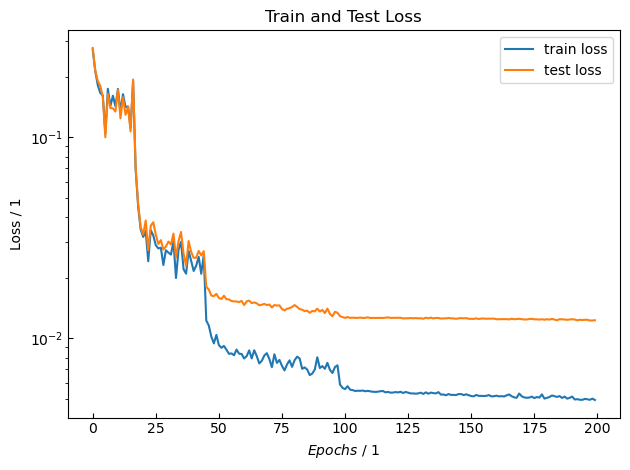

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_016.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999141009366702 , R^2(NH3) = 0.9999133383861118
Test Dataset: R^2(H2) = 0.9997842258512012 , R^2(NH3) = 0.999488622073574
Max Error Training: |x_H2 - x_H2,pred| = 0.031066990803122696 , |x_NH3 - x_NH3,pred| = 0.010036170353710239
Max Error Test: |x_H2 - x_H2,pred| = 0.010700397373734849 , |x_NH3 - x_NH3,pred| = 0.01673847921900054


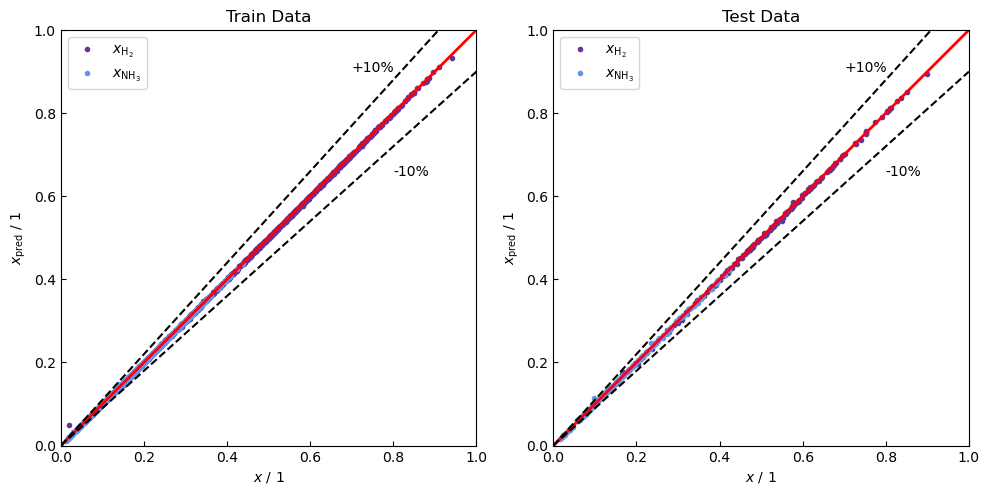

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

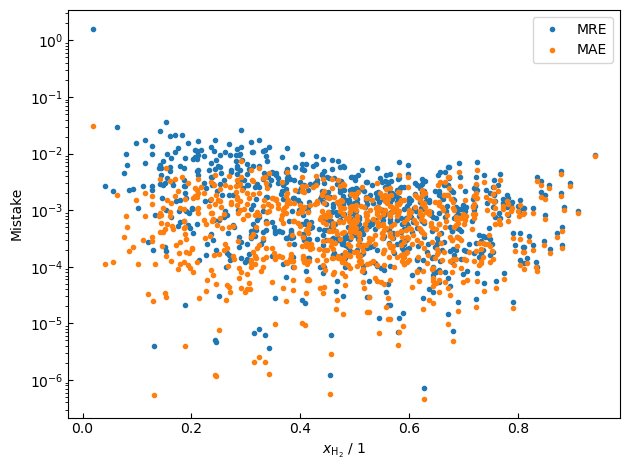

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

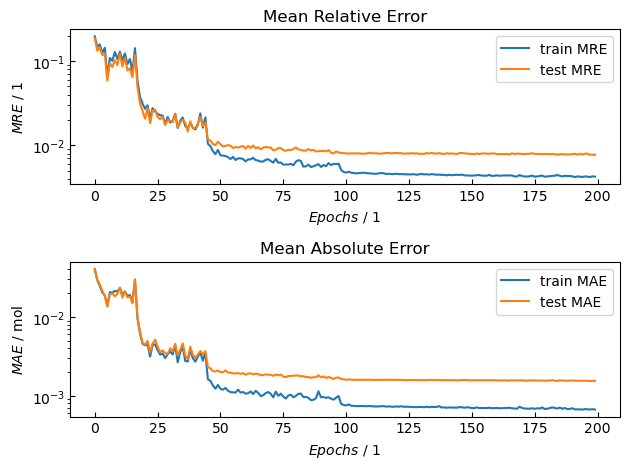

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

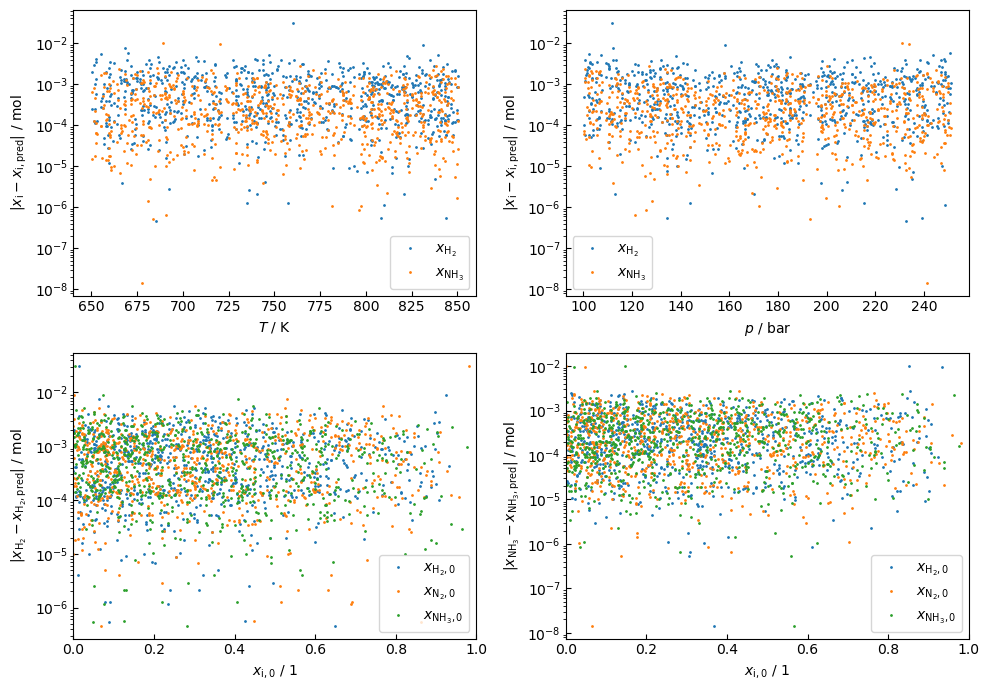

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

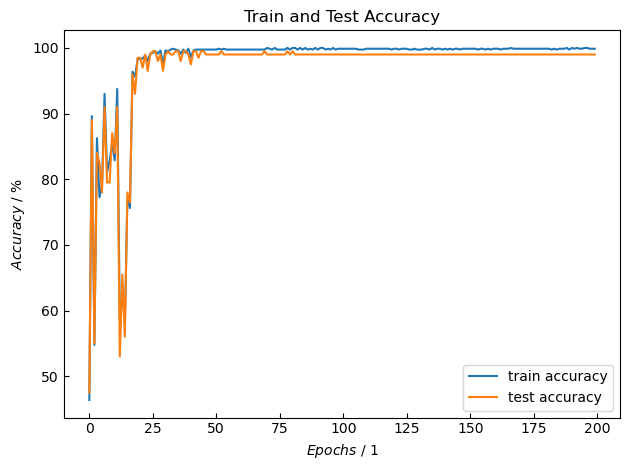

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 0.0547,  0.5061,  0.0260,  0.3826, -0.4165],
        [ 0.9248,  1.6671, -0.4233,  1.4710, -1.0881],
        [ 0.5683,  1.5450,  0.6013, -0.8992,  0.3290],
        [ 1.4930, -0.5700, -0.4010,  0.0345,  0.3583],
        [ 1.4633, -0.2224,  0.3098, -0.7752,  0.4882],
        [ 0.4284,  1.7118, -1.1819,  2.0708, -0.9566],
        [-0.5982, -1.6544,  2.4046, -1.2180, -1.1149],
        [ 1.1961, -0.2350,  1.6416, -1.1335, -0.4525],
        [ 0.5140, -1.5102,  1.5352, -0.9713, -0.5139],
        [-0.1491,  0.1733, -0.6346,  0.9814, -0.3803],
        [ 1.5081, -1.6287,  1.3576, -0.6032, -0.7159],
        [ 1.1900,  0.7035, -0.0235, -1.0976,  1.1448],
        [-1.2516,  0.5024, -1.3103,  0.0430,  1.2420],
        [-0.1311,  0.7007, -0.0128, -0.8538,  0.8852],
        [-1.2624, -1.4083, -1.4108,  2.5834, -1.2559],
        [ 1.1188, -0.3416,  0.3875, -1.1822,  0.8280],
        [-1.4830,  0.9402, -0.0035, -1.1798,  1.2093],
        [ 0.8472, -1.3921,  0.1063, -0.9773,  0.8946],
        [-

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 0.1378, -0.1287, -0.2604, -0.4356, -0.0775],
         [-0.3285, -0.1179,  0.4297, -0.3477, -0.0955],
         [ 0.0606, -0.0011, -0.3071,  0.1017, -0.2202],
         [ 0.1287, -0.0877,  0.0449, -0.4336,  0.0007],
         [ 0.2528,  0.0082,  0.0391,  0.2064,  0.1124],
         [-0.0185,  0.0964, -0.3001,  0.1500, -0.3608],
         [ 0.3172, -0.1894, -0.2660, -0.0525,  0.2937],
         [ 0.4446,  0.2712, -0.0225,  0.3813,  0.1833],
         [-0.2698,  0.0980,  0.0942, -0.2076,  0.3518],
         [ 0.0431, -0.0042,  0.2425, -0.3845, -0.1042],
         [ 0.1755, -0.0010, -0.2540,  0.2314, -0.2683],
         [-0.3042,  0.0807,  0.1572, -0.2073, -0.2012],
         [-0.0166,  0.0953,  0.3110, -0.0972,  0.0444],
         [-0.4652,  0.3820,  0.4616, -0.4366, -0.0715],
         [-0.0647,  0.0069,  0.1874, -0.2933,  0.4362],
         [-0.0416, -0.1231, -0.2753,  0.3431, -0.1212],
         [-0.0479,  0.0244,  0.0143, -0.3792, -0.1614],
         [ 0.3290,  0.112

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.0938, 0.0851, 0.9132, 0.3316, 0.0543],
        [0.9865, 0.6404, 0.5315, 0.7199, 0.4452]])
tensor([[ 0.1894, -0.0008],
        [ 0.0636, -0.5885]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.0787e+00,  1.0912e+00,  3.7175e-02, -1.3056e+00,  1.2979e+00],
        [-1.4023e+00,  8.0192e-02,  1.9006e+00, -1.0370e+00, -8.0534e-01],
        [ 1.6201e-01, -1.6405e+00, -8.0775e-01, -1.7207e-01,  9.6858e-01],
        [-7.1468e-01, -1.2815e+00,  2.0716e+00, -9.3383e-01, -1.0786e+00],
        [-1.6716e+00,  3.0497e-01,  2.2128e+00, -1.0556e+00, -1.0926e+00],
        [ 1.4271e+00, -1.3029e+00,  9.9394e-01, -1.1879e+00,  2.3867e-01],
        [-3.3372e-01, -1.1729e+00,  1.5227e+00, -1.1441e+00, -3.2502e-01],
        [-7.2814e-01, -1.4142e+00,  2.4807e-01,  6.1483e-01, -8.7185e-01],
        [ 1.4953e+00, -3.5906e-01, -1.7848e-01,  9.6290e-01, -8.0900e-01],
        [ 3.9241e-01, -1.5774e+00,  1.3533e-01, -6.1199e-01,  4.9269e-01],
        [-4.6276e-01,  7.1749e-01, -2.9994e-01, -6.6325e-01,  9.7225e-01],
        [ 1.1709e+00,  1.4049e+00, -1.1886e+00,  8.9980e-01,  2.4680e-01],
        [-1.1109e+00, -5.5717e-01, -1.2407e+00,  2.2930e+00, -1.1260e+00],
        [ 1.5685e+00,  2.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()